# Library

In [ ]:
# pip install -r ../../requirements.txt 


In [ ]:

# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
# Import library tambahan untuk EDA dan preprocessing
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import re
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import numpy as np
import torch
from collections import Counter


plt.style.use('default')
sns.set_palette("husl")



print("Library tambahan berhasil diimport!")

Library tambahan berhasil diimport!


In [15]:
print("Dependencies check:")

try:
    import transformers
    print(f"transformers: {transformers.__version__}")
except ImportError:
    print("transformers not installed")

try:
    import torch
    print(f"torch: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
except ImportError:
    print("❌ torch not installed")

try:
    import datasets
    print(f"datasets: {datasets.__version__}")
except ImportError:
    print("datasets not installed")

try:
    import evaluate
    print(f"evaluate: {evaluate.__version__}")
except ImportError:
    print("evaluate not installed")

Dependencies check:
transformers: 4.51.3
torch: 2.5.1+cu121
CUDA available: True
datasets: 3.5.0
evaluate: 0.4.3


---

# EDA

In [2]:


with open('../../Datasets/PUBLIC/data.json', 'r') as f:
    data = json.load(f)

df = pd.json_normalize(data)

In [3]:
df

verdict  indictment  lawyer    id  owner  \
0    guilty    subsider   False  2743  agree   
1    guilty  alternatif   False  2744  agree   
2    guilty     tunggal   False  2745  agree   
3    guilty          NA   False  2746  agree   
4    guilty     tunggal   False  2747  agree   
..      ...         ...     ...   ...    ...   
988  guilty     tunggal   False  2738  jafar   
989  guilty     tunggal   False  2739  jafar   
990  guilty          NA   False  2740  jafar   
991  guilty  alternatif   False  2741  jafar   
992  guilty     tunggal   False  2742  jafar   

                                             text-tags  \
0    [O, O, B-Nomor Putusan, I-Nomor Putusan, O, O,...   
1    [O, O, B-Nomor Putusan, I-Nomor Putusan, O, O,...   
2    [O, O, B-Nomor Putusan, O, O, O, O, O, O, O, B...   
3    [O, O, O, B-Nomor Putusan, O, O, O, O, O, O, O...   
4    [O, O, B-Nomor Putusan, I-Nomor Putusan, O, O,...   
..                                                 ...   
988  [O, O, O, B-Nomor Putusan, I-Nomor Putusan, I-...   
989  [O, O, O, O, O, O, O, O, O, B-Nomor Putusan, O...   
990  [O, O, O, B-Nomor Putusan, O, O, O, O, O, O, O...   
991  [O, O, O, B-Nomor Putusan, O, O, O, O, O, O, O...   
992  [O, O, O, B-Nomor Putusan, O, O, O, O, O, O, O...   

                                                  text  
0    [﻿putusan, nomor, 325/pid.b/2015/pn, bwi, demi...  
1    [﻿putusan, nomor, 285/pid.b/2016/pn, sda, demi...  
2    [﻿putusan, nomor:, 80/pid.b/2014/pn.spg, demi,...  
3    [﻿putusan, nomor, :, 325/pid.sus/2012/pn.ta., ...  
4    [﻿putusan, nomor, 92/pid.b/2015/pn, slw., demi...  
..                                                 ...  
988  [﻿1, putusan, no., 21/pid., b/2012/pn., tmg, “...  
989  [﻿dir1ektori, putusan, mahkamah, agung, republ...  
990  [﻿putusan, nomor, :, 376/pid.b/2012/pn.kdi, de...  
991  [﻿putusan, nomor, :, 79/pid.sus/2015/pn.blb, d...  
992  [﻿putusan, nomor, :, 121/pid.b/2010/pn.smp, de...  

[993 rows x 7 columns]

In [ ]:

print(f"Shape DataFrame: {df.shape}")
print(f"\nColumns DataFrame:")
print(df.columns.tolist())
print(f"\nInfo DataFrame:")
print(df.info())


Shape DataFrame: (993, 7)

Columns DataFrame:
['verdict', 'indictment', 'lawyer', 'id', 'owner', 'text-tags', 'text']

Info DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   verdict     993 non-null    object
 1   indictment  993 non-null    object
 2   lawyer      993 non-null    bool  
 3   id          993 non-null    int64 
 4   owner       993 non-null    object
 5   text-tags   993 non-null    object
 6   text        993 non-null    object
dtypes: bool(1), int64(1), object(5)
memory usage: 47.6+ KB
None


In [9]:
# Fungsi untuk mengekstrak semua tags unik
def get_all_tags(df):
    all_tags = []
    for tags in df['text-tags']:
        all_tags.extend(tags)
    return Counter(all_tags)

# Dapatkan distribusi tags
tag_counts = get_all_tags(df)
print("Distribusi Tags NER:")
for tag, count in tag_counts.most_common():
    print(f"{tag}: {count:,}")

# Hitung persentase non-O tags
total_tags = sum(tag_counts.values())
non_o_tags = sum(count for tag, count in tag_counts.items() if tag != 'O')
print(f"\nTotal tags: {total_tags:,}")
print(f"Non-O tags: {non_o_tags:,} ({non_o_tags/total_tags*100:.2f}%)")
print(f"O tags: {tag_counts['O']:,} ({tag_counts['O']/total_tags*100:.2f}%)")

Distribusi Tags NER:
O: 5,769,685
I-Melanggar UU (Dakwaan): 12,798
I-Melanggar UU (Pertimbangan Hukum): 11,712
I-Putusan Hukuman: 10,444
I-Tuntutan Hukuman: 8,662
I-Melanggar UU (Tuntutan): 8,467
I-Nama Saksi: 8,446
I-Jenis Perkara: 8,400
I-Nama Hakim Anggota: 4,943
I-Nama Terdakwa: 4,182
B-Nama Saksi: 3,948
I-Jenis Amar: 3,254
I-Tanggal Kejadian: 3,228
I-Nama Hakim Ketua: 2,521
I-Nama Pengadilan: 2,255
I-Nama Jaksa: 2,048
I-Tanggal Putusan: 2,000
B-Nama Hakim Anggota: 1,944
I-Jenis Dakwaan: 1,833
I-Nama Panitera: 1,659
B-Tanggal Kejadian: 1,635
B-Melanggar UU (Dakwaan): 1,368
B-Melanggar UU (Pertimbangan Hukum): 1,332
B-Nama Terdakwa: 1,236
B-Tuntutan Hukuman: 1,201
B-Putusan Hukuman: 1,173
I-Tingkat Kasus: 1,122
B-Nomor Putusan: 993
B-Nama Pengadilan: 993
B-Nama Hakim Ketua: 990
B-Nama Panitera: 990
B-Jenis Amar: 989
B-Tanggal Putusan: 987
B-Nama Jaksa: 979
B-Tingkat Kasus: 975
B-Melanggar UU (Tuntutan): 951
B-Jenis Perkara: 950
B-Jenis Dakwaan: 869
I-Nomor Putusan: 816
I-Nama Pengac

In [ ]:
# Analisis jenis entity yang ada
def analyze_entity_types(df):

    entity_types = set()
    entity_examples = {}
    
    for idx in range(len(df)):
        text = df.iloc[idx]['text']
        tags = df.iloc[idx]['text-tags']
        
        current_entity = []
        current_entity_type = None
        
        for token, tag in zip(text, tags):
            if tag.startswith('B-'):
                # Simpan entity sebelumnya
                if current_entity and current_entity_type:
                    entity_text = ' '.join(current_entity)
                    if current_entity_type not in entity_examples:
                        entity_examples[current_entity_type] = []
                    if len(entity_examples[current_entity_type]) < 5:  # Simpan max 5 contoh
                        entity_examples[current_entity_type].append(entity_text)
                
                # Mulai entity baru
                current_entity_type = tag[2:]
                entity_types.add(current_entity_type)
                current_entity = [token]
            
            elif tag.startswith('I-') and current_entity_type == tag[2:]:
                current_entity.append(token)
            
            else:  # tag == 'O' atau inconsistent I-tag
                # Simpan entity yang sedang diproses
                if current_entity and current_entity_type:
                    entity_text = ' '.join(current_entity)
                    if current_entity_type not in entity_examples:
                        entity_examples[current_entity_type] = []
                    if len(entity_examples[current_entity_type]) < 5:
                        entity_examples[current_entity_type].append(entity_text)
                
                current_entity = []
                current_entity_type = None
        
        # Handle entity di akhir sequence
        if current_entity and current_entity_type:
            entity_text = ' '.join(current_entity)
            if current_entity_type not in entity_examples:
                entity_examples[current_entity_type] = []
            if len(entity_examples[current_entity_type]) < 5:
                entity_examples[current_entity_type].append(entity_text)
    
    return entity_types, entity_examples

# Analisis entity types
print("Menganalisis jenis-jenis entity...")
entity_types, entity_examples = analyze_entity_types(df)

print(f"\nDitemukan {len(entity_types)} jenis entity:")
for entity_type in sorted(entity_types):
    print(f"\n• {entity_type}:")
    if entity_type in entity_examples:
        for example in entity_examples[entity_type]:
            print(f"  - '{example}'")
    else:
        print(f"  - (tidak ada contoh)")

Menganalisis jenis-jenis entity...

Ditemukan 20 jenis entity:

• Jenis Amar:
  - 'menjatuhkan pidana kepada terdakwa'
  - 'menjatuhkan pidana kepada terdakwa'
  - 'menjatuhkan pidana terhadap terdakwa'
  - 'menjatuhkan pidana terhadap terdakwa'
  - 'menjatuhkan pidana kepada terdakwa'

• Jenis Dakwaan:
  - 'dakwaan alternatif-subsidairitas'
  - 'dakwaan oleh penuntut umum yang dibuat secara alternatif,'
  - 'dakwaan tunggal'
  - 'dakwaan tunggal'
  - 'dakwaan alternatif'

• Jenis Perkara:
  - '“penggelapan dengan pemberatan”'
  - '“pengelapan dalam jabatan”'
  - 'penganiayaan;'
  - '“dengan sengaja menyeienggarakan kegiatan atau proses produksi, penyimpanan, pengangkutan dan atau peredaran pangan dalam keadaan yang tidak memenuhi persyaratan sanitasi,"'
  - '“pencurian dengan pemberatan”'

• Melanggar UU (Dakwaan):
  - '374 kuhp,'
  - '372 kuhp,'
  - '362 kuhp;'
  - 'pasal 374 kuhp'
  - 'pasal 372 kuhp'

• Melanggar UU (Pertimbangan Hukum):
  - 'pasal 374 kuhp'
  - 'pasal 374 kuhp'
  

In [ ]:

def check_annotation_consistency(df):
    """
    Mengecek konsistensi anotasi BIO
    """
    errors = []
    
    for idx in range(len(df)):
        tags = df.iloc[idx]['text-tags']
        text = df.iloc[idx]['text']
        
        for i, tag in enumerate(tags):
            # Check 1: I-tag harus didahului oleh B-tag atau I-tag dengan tipe yang sama
            if tag.startswith('I-'):
                entity_type = tag[2:]
                if i == 0:  # I-tag di awal sequence
                    errors.append({
                        'doc_id': idx,
                        'position': i,
                        'error': f'I-tag at beginning: {tag}',
                        'context': ' '.join(text[max(0, i-2):i+3])
                    })
                else:
                    prev_tag = tags[i-1]
                    if not (prev_tag == f'B-{entity_type}' or prev_tag == f'I-{entity_type}'):
                        errors.append({
                            'doc_id': idx,
                            'position': i,
                            'error': f'I-tag without proper B-tag: {prev_tag} -> {tag}',
                            'context': ' '.join(text[max(0, i-2):i+3])
                        })
    
    return errors

# Cek konsistensi anotasi
print("Mengecek konsistensi anotasi BIO...")
errors = check_annotation_consistency(df)

if errors:
    print(f"\nDitemukan {len(errors)} error konsistensi:")
    for i, error in enumerate(errors[:10]):  # Tampilkan 10 error pertama
        print(f"{i+1}. Doc {error['doc_id']}, Pos {error['position']}: {error['error']}")
        print(f"   Context: '{error['context']}'")
    
    if len(errors) > 10:
        print(f"\n... dan {len(errors)-10} error lainnya")
else:
    print("\nTidak ditemukan error konsistensi BIO!")

Mengecek konsistensi anotasi BIO...

Ditemukan 1 error konsistensi:
1. Doc 411, Pos 8253: I-tag without proper B-tag: I-Nama Panitera -> I-Nama Jaksa
   Context: 'asep pulah m, sh., panitera'


In [12]:
# Fungsi untuk menampilkan anotasi secara visual
def display_annotations(df, idx, max_tokens=50):
    """
    Menampilkan teks dengan highlight anotasi untuk review manual
    """
    text = df.iloc[idx]['text']
    tags = df.iloc[idx]['text-tags']
    
    print(f"\n=== DOCUMENT {idx} (ID: {df.iloc[idx]['id']}) ===")
    print(f"Verdict: {df.iloc[idx]['verdict']}")
    print(f"Indictment: {df.iloc[idx]['indictment']}")
    print(f"Lawyer: {df.iloc[idx]['lawyer']}")
    print(f"Owner: {df.iloc[idx]['owner']}")
    print("\n--- ANNOTATED TEXT ---")
    
    # Batasi jumlah token untuk display
    display_text = text[:max_tokens]
    display_tags = tags[:max_tokens]
    
    current_entity = []
    current_entity_type = None
    
    for i, (token, tag) in enumerate(zip(display_text, display_tags)):
        if tag.startswith('B-'):
            # Selesaikan entity sebelumnya jika ada
            if current_entity:
                entity_text = ' '.join(current_entity)
                print(f"[{entity_text}]({current_entity_type})", end=' ')
                current_entity = []
            
            # Mulai entity baru
            current_entity_type = tag[2:]
            current_entity = [token]
        
        elif tag.startswith('I-'):
            # Lanjutkan entity yang sama
            if current_entity_type == tag[2:]:
                current_entity.append(token)
            else:
                # Tag inconsistent, print as separate
                if current_entity:
                    entity_text = ' '.join(current_entity)
                    print(f"[{entity_text}]({current_entity_type})", end=' ')
                current_entity_type = tag[2:]
                current_entity = [token]
        
        else:  # tag == 'O'
            # Selesaikan entity sebelumnya jika ada
            if current_entity:
                entity_text = ' '.join(current_entity)
                print(f"[{entity_text}]({current_entity_type})", end=' ')
                current_entity = []
                current_entity_type = None
            
            # Print token biasa
            print(token, end=' ')
    
    # Selesaikan entity terakhir jika ada
    if current_entity:
        entity_text = ' '.join(current_entity)
        print(f"[{entity_text}]({current_entity_type})", end=' ')
    
    print("\n")
    
    # Tampilkan semua entities yang ditemukan
    entities = []
    current_entity = []
    current_entity_type = None
    
    for token, tag in zip(text, tags):
        if tag.startswith('B-'):
            if current_entity:
                entities.append((' '.join(current_entity), current_entity_type))
                current_entity = []
            current_entity_type = tag[2:]
            current_entity = [token]
        elif tag.startswith('I-') and current_entity_type == tag[2:]:
            current_entity.append(token)
        else:
            if current_entity:
                entities.append((' '.join(current_entity), current_entity_type))
                current_entity = []
                current_entity_type = None
    
    if current_entity:
        entities.append((' '.join(current_entity), current_entity_type))
    
    if entities:
        print("--- EXTRACTED ENTITIES ---")
        for entity, entity_type in entities:
            print(f"• {entity_type}: '{entity}'")
    else:
        print("--- NO ENTITIES FOUND ---")
    
    print("\n" + "="*50)

# Tampilkan beberapa contoh dokumen dengan anotasi
print("MANUAL REVIEW - Contoh Anotasi:")
for i in range(min(5, len(df))):
    display_annotations(df, i, max_tokens=30)

MANUAL REVIEW - Contoh Anotasi:

=== DOCUMENT 0 (ID: 2743) ===
Verdict: guilty
Indictment: subsider
Lawyer: False
Owner: agree

--- ANNOTATED TEXT ---
﻿putusan nomor [325/pid.b/2015/pn bwi](Nomor Putusan) demi keadilan berdasarkan ketuhanan yang maha esa [pengadilan negeri banyuwangi](Nama Pengadilan) yang mengadili dan memutus perkara pidana dengan acara pemeriksaan biasa dalam [tingkat pertama](Tingkat Kasus) menjatuhkan putusan sebagai 

--- EXTRACTED ENTITIES ---
• Nomor Putusan: '325/pid.b/2015/pn bwi'
• Nama Pengadilan: 'pengadilan negeri banyuwangi'
• Tingkat Kasus: 'tingkat pertama'
• Nama Terdakwa: 'suyanto al. yanto;'
• Jenis Perkara: '“penggelapan dengan pemberatan”'
• Melanggar UU (Tuntutan): 'pasal 374 kuhpidana'
• Tuntutan Hukuman: 'penjara selama 1(satu) tahun 4(empat)'
• Nama Saksi: 'slamet sugianto,'
• Nama Saksi: 'supron,'
• Nama Saksi: 'suyadi,'
• Tanggal Kejadian: '14 maret 2015'
• Jenis Dakwaan: 'dakwaan alternatif-subsidairitas'
• Melanggar UU (Dakwaan): '374 kuhp

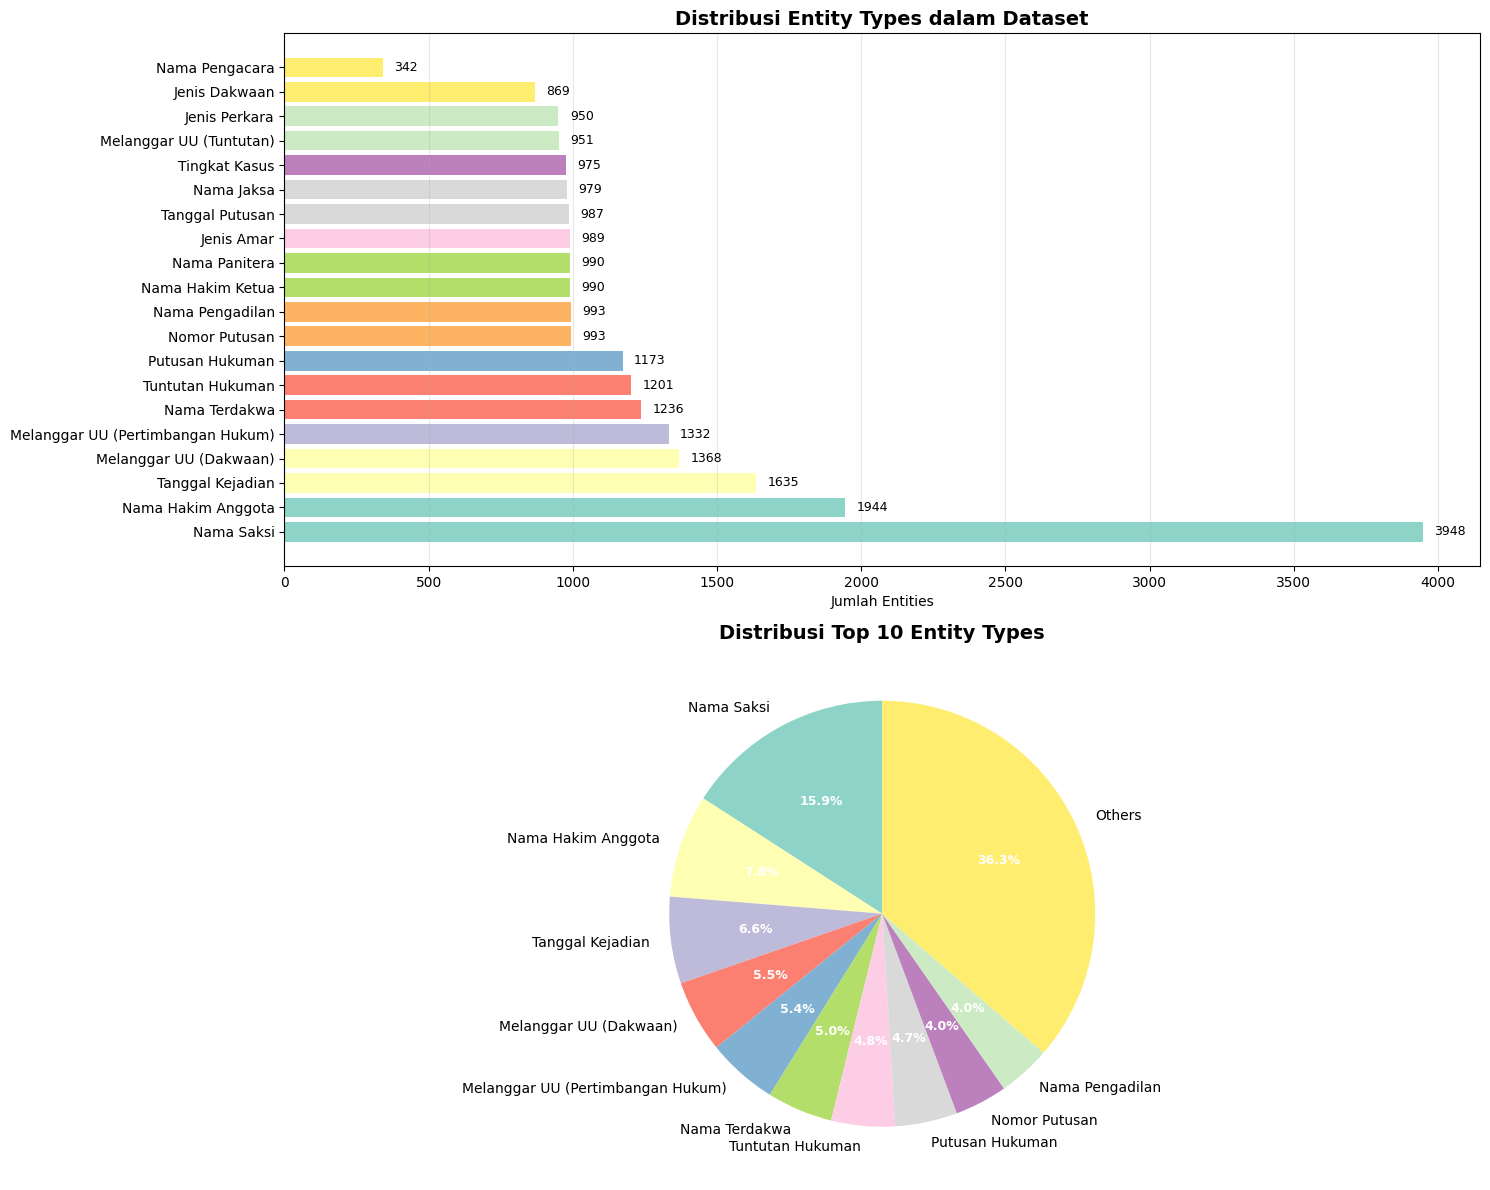


Total unique entity types: 20
Total entities found: 24845


In [13]:
# Visualisasi distribusi entity types
def visualize_entity_distribution(df):
    """
    Membuat visualisasi distribusi entity types
    """
    # Hitung jumlah entities per type
    entity_counts = {}
    
    for idx in range(len(df)):
        text = df.iloc[idx]['text']
        tags = df.iloc[idx]['text-tags']
        
        current_entity_type = None
        
        for token, tag in zip(text, tags):
            if tag.startswith('B-'):
                entity_type = tag[2:]
                if entity_type not in entity_counts:
                    entity_counts[entity_type] = 0
                entity_counts[entity_type] += 1
                current_entity_type = entity_type
    
    # Sort dan buat plot
    sorted_entities = sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot 1: Horizontal bar chart untuk semua entities
    entity_names = [item[0] for item in sorted_entities]
    entity_values = [item[1] for item in sorted_entities]
    
    bars = ax1.barh(range(len(entity_names)), entity_values, color=plt.cm.Set3(np.linspace(0, 1, len(entity_names))))
    ax1.set_yticks(range(len(entity_names)))
    ax1.set_yticklabels(entity_names, fontsize=10)
    ax1.set_xlabel('Jumlah Entities')
    ax1.set_title('Distribusi Entity Types dalam Dataset', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Tambahkan nilai di ujung bar
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax1.text(width + max(entity_values)*0.01, bar.get_y() + bar.get_height()/2, 
                f'{int(width)}', ha='left', va='center', fontsize=9)
    
    # Plot 2: Pie chart untuk top 10 entities
    top_10 = sorted_entities[:10]
    others_count = sum([item[1] for item in sorted_entities[10:]])
    
    pie_labels = [item[0] for item in top_10]
    pie_values = [item[1] for item in top_10]
    
    if others_count > 0:
        pie_labels.append('Others')
        pie_values.append(others_count)
    
    wedges, texts, autotexts = ax2.pie(pie_values, labels=pie_labels, autopct='%1.1f%%', 
                                       startangle=90, colors=plt.cm.Set3(np.linspace(0, 1, len(pie_values))))
    ax2.set_title('Distribusi Top 10 Entity Types', fontsize=14, fontweight='bold')
    
    # Rotate labels for better readability
    for text in texts:
        text.set_fontsize(10)
    for autotext in autotexts:
        autotext.set_fontsize(9)
        autotext.set_color('white')
        autotext.set_weight('bold')
    
    plt.tight_layout()
    plt.show()
    
    return entity_counts

# Buat visualisasi
entity_counts = visualize_entity_distribution(df)
print(f"\nTotal unique entity types: {len(entity_counts)}")
print(f"Total entities found: {sum(entity_counts.values())}")

---

# Preprocessing

In [17]:
# Load pembagian dataset berdasarkan ID dari folder PUBLIC
print("Loading dataset splits from PUBLIC folder...")

# Load train IDs
train_ids = pd.read_csv('../../Datasets/PUBLIC/train.ids.csv', header=None, names=['id'])
print(f"Train IDs loaded: {len(train_ids)} documents")

# Load validation IDs  
val_ids = pd.read_csv('../../Datasets/PUBLIC/val.ids.csv', header=None, names=['id'])
print(f"Validation IDs loaded: {len(val_ids)} documents")

# Load test IDs
test_ids = pd.read_csv('../../Datasets/PUBLIC/test.ids.csv', header=None, names=['id'])
print(f"Test IDs loaded: {len(test_ids)} documents")

# Konversi ke set untuk lookup yang lebih cepat
train_ids_set = set(train_ids['id'].tolist())
val_ids_set = set(val_ids['id'].tolist())
test_ids_set = set(test_ids['id'].tolist())

print(f"\nDataset split summary:")
print(f"Train: {len(train_ids_set)} documents")
print(f"Validation: {len(val_ids_set)} documents")
print(f"Test: {len(test_ids_set)} documents")
print(f"Total: {len(train_ids_set) + len(val_ids_set) + len(test_ids_set)} documents")

# Verifikasi tidak ada overlap
overlap_train_val = train_ids_set.intersection(val_ids_set)
overlap_train_test = train_ids_set.intersection(test_ids_set)
overlap_val_test = val_ids_set.intersection(test_ids_set)

print(f"\nOverlap check:")
print(f"Train-Val overlap: {len(overlap_train_val)} documents")
print(f"Train-Test overlap: {len(overlap_train_test)} documents")
print(f"Val-Test overlap: {len(overlap_val_test)} documents")



Loading dataset splits from PUBLIC folder...
Train IDs loaded: 695 documents
Validation IDs loaded: 30 documents
Test IDs loaded: 268 documents

Dataset split summary:
Train: 695 documents
Validation: 30 documents
Test: 268 documents
Total: 993 documents

Overlap check:
Train-Val overlap: 0 documents
Train-Test overlap: 0 documents
Val-Test overlap: 0 documents


In [ ]:
# Split dataframe berdasarkan ID yang sudah ditentukan
print("Splitting dataframe based on predefined IDs...")

# Filter dataframe berdasarkan ID
train_df = df[df['id'].isin(train_ids_set)].copy().reset_index(drop=True)
val_df = df[df['id'].isin(val_ids_set)].copy().reset_index(drop=True)
test_df = df[df['id'].isin(test_ids_set)].copy().reset_index(drop=True)

print(f"\nDataFrame splits created:")
print(f"Train DataFrame: {len(train_df)} documents")
print(f"Validation DataFrame: {len(val_df)} documents")
print(f"Test DataFrame: {len(test_df)} documents")

# Verifikasi bahwa semua dokumen dari main dataframe sudah terbagi
total_split = len(train_df) + len(val_df) + len(test_df)
print(f"\nOriginal dataset: {len(df)} documents")
print(f"Split total: {total_split} documents")

if total_split == len(df):
    print("All documents successfully assigned to splits!")
else:
    missing = len(df) - total_split
    print(f"{missing} documents are missing from splits")
    
    # Cari dokumen yang tidak ada di splits
    all_split_ids = train_ids_set.union(val_ids_set).union(test_ids_set)
    original_ids = set(df['id'].tolist())
    missing_ids = original_ids - all_split_ids
    if missing_ids:
        print(f"Missing IDs: {list(missing_ids)[:10]}...")  # Show first 10

# Cek distribusi verdict di setiap split
print(f"\nVerdict distribution per split:")
print(f"\nTrain verdict distribution:")
print(train_df['verdict'].value_counts(normalize=True).round(3))

print(f"\nValidation verdict distribution:")
print(val_df['verdict'].value_counts(normalize=True).round(3))

print(f"\nTest verdict distribution:")
print(test_df['verdict'].value_counts(normalize=True).round(3))

Splitting dataframe based on predefined IDs...

DataFrame splits created:
Train DataFrame: 695 documents
Validation DataFrame: 30 documents
Test DataFrame: 268 documents

Original dataset: 993 documents
Split total: 993 documents
✅ All documents successfully assigned to splits!

Verdict distribution per split:

Train verdict distribution:
verdict
guilty    0.957
bebas     0.026
lepas     0.017
Name: proportion, dtype: float64

Validation verdict distribution:
verdict
guilty    1.0
Name: proportion, dtype: float64

Test verdict distribution:
verdict
guilty    0.940
bebas     0.034
lepas     0.026
Name: proportion, dtype: float64


In [19]:
# Setup XLM-RoBERTa tokenizer untuk NER
print("Setting up XLM-RoBERTa tokenizer...")

# Load tokenizer XLM-RoBERTa
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"Loaded tokenizer: {model_name}")
print(f"Vocab size: {tokenizer.vocab_size}")
print(f"Special tokens: {tokenizer.special_tokens_map}")
print(f"CLS token: '{tokenizer.cls_token}' (ID: {tokenizer.cls_token_id})")
print(f"SEP token: '{tokenizer.sep_token}' (ID: {tokenizer.sep_token_id})")
print(f"PAD token: '{tokenizer.pad_token}' (ID: {tokenizer.pad_token_id})")
print(f"UNK token: '{tokenizer.unk_token}' (ID: {tokenizer.unk_token_id})")

Setting up XLM-RoBERTa tokenizer...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Loaded tokenizer: xlm-roberta-base
Vocab size: 250002
Special tokens: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}
CLS token: '<s>' (ID: 0)
SEP token: '</s>' (ID: 2)
PAD token: '<pad>' (ID: 1)
UNK token: '<unk>' (ID: 3)


In [20]:
# Test tokenisasi pada contoh kecil
sample_tokens = df.iloc[0]['text'][:10]  # First 10 tokens
print(f"\n Testing tokenization on sample:")
print(f"Original tokens: {sample_tokens}")


 Testing tokenization on sample:
Original tokens: ['\ufeffputusan', 'nomor', '325/pid.b/2015/pn', 'bwi', 'demi', 'keadilan', 'berdasarkan', 'ketuhanan', 'yang', 'maha']


In [23]:


# Tokenize dengan berbagai parameter
test_encoding = tokenizer(
    sample_tokens,
    is_split_into_words=True,
    add_special_tokens=True,
    return_offsets_mapping=True,
    return_attention_mask=True
)

print(f"\nTokenization result:")
print(f"Input IDs: {test_encoding['input_ids']}")
print(f"Tokens: {tokenizer.convert_ids_to_tokens(test_encoding['input_ids'])}")
print(f"Word IDs: {test_encoding.word_ids()}")
print(f"Attention mask: {test_encoding['attention_mask']}")


Tokenization result:
Input IDs: [0, 101485, 66, 71161, 112467, 64, 45226, 5, 275, 24301, 64, 254, 19, 90998, 14, 41000, 186678, 33788, 120855, 66150, 119, 13490, 2]
Tokens: ['<s>', '▁putus', 'an', '▁nomor', '▁325', '/', 'pid', '.', 'b', '/2015', '/', 'p', 'n', '▁bw', 'i', '▁demi', '▁keadilan', '▁berdasarkan', '▁ketu', 'hanan', '▁yang', '▁maha', '</s>']
Word IDs: [None, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, None]
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [24]:
# Buat mapping label NER ke ID numerik
print("Creating label mapping for NER...")

def create_label_mapping(df):
    """
    Membuat mapping dari label NER ke ID numerik
    """
    all_labels = set()
    
    # Kumpulkan semua unique labels
    for tags in df['text-tags']:
        all_labels.update(tags)
    
    # Sort labels untuk konsistensi (O akan di index 0)
    sorted_labels = sorted(list(all_labels))
    
    # Pastikan 'O' di index 0 untuk konsistensi
    if 'O' in sorted_labels:
        sorted_labels.remove('O')
        sorted_labels = ['O'] + sorted_labels
    
    # Buat mapping
    label2id = {label: idx for idx, label in enumerate(sorted_labels)}
    id2label = {idx: label for label, idx in label2id.items()}
    
    return label2id, id2label, sorted_labels

# Create mappings
label2id, id2label, all_labels = create_label_mapping(df)

print(f"\n📊 Label mapping created:")
print(f"Total unique labels: {len(all_labels)}")
print(f"Label 'O' has ID: {label2id['O']}")

Creating label mapping for NER...

📊 Label mapping created:
Total unique labels: 41
Label 'O' has ID: 0


In [25]:
print(f"\nSample label mapping (first 15):")
for i, (label, idx) in enumerate(list(label2id.items())[:15]):
    print(f"{idx:2d}: {label}")

if len(label2id) > 15:
    print(f"... dan {len(label2id)-15} labels lainnya")

# Analisis distribusi entity types (tanpa B-/I- prefix)
entity_types = set()
for label in all_labels:
    if label != 'O':
        entity_type = label.split('-', 1)[1] if '-' in label else label
        entity_types.add(entity_type)

print(f"\nEntity types found: {len(entity_types)}")
print(f"Entity types: {sorted(list(entity_types))[:10]}...")


Sample label mapping (first 15):
 0: O
 1: B-Jenis Amar
 2: B-Jenis Dakwaan
 3: B-Jenis Perkara
 4: B-Melanggar UU (Dakwaan)
 5: B-Melanggar UU (Pertimbangan Hukum)
 6: B-Melanggar UU (Tuntutan)
 7: B-Nama Hakim Anggota
 8: B-Nama Hakim Ketua
 9: B-Nama Jaksa
10: B-Nama Panitera
11: B-Nama Pengacara
12: B-Nama Pengadilan
13: B-Nama Saksi
14: B-Nama Terdakwa
... dan 26 labels lainnya

Entity types found: 20
Entity types: ['Jenis Amar', 'Jenis Dakwaan', 'Jenis Perkara', 'Melanggar UU (Dakwaan)', 'Melanggar UU (Pertimbangan Hukum)', 'Melanggar UU (Tuntutan)', 'Nama Hakim Anggota', 'Nama Hakim Ketua', 'Nama Jaksa', 'Nama Panitera']...


In [26]:
# Fungsi untuk tokenisasi dan alignment labels dengan subword tokens
def tokenize_and_align_labels(examples_df, tokenizer, label2id, max_length=512):
    """
    Tokenisasi teks dan alignment labels untuk subword tokens
    Args:
        examples_df: DataFrame dengan kolom 'text' dan 'text-tags'
        tokenizer: HuggingFace tokenizer
        label2id: Dictionary mapping label ke ID
        max_length: Maksimum panjang sequence
    
    Returns:
        List of dictionaries dengan keys: input_ids, attention_mask, labels
    """
    tokenized_inputs = []
    
    print(f"Tokenizing {len(examples_df)} documents...")
    
    for idx in range(len(examples_df)):
        if idx % 100 == 0:  # Progress indicator
            print(f"  Processed {idx}/{len(examples_df)} documents...")
            
        tokens = examples_df.iloc[idx]['text']
        labels = examples_df.iloc[idx]['text-tags']
        
        # Pastikan panjang tokens dan labels sama
        if len(tokens) != len(labels):
            print(f"Length mismatch at index {idx}: tokens={len(tokens)}, labels={len(labels)}")
            continue
        
        # Tokenisasi dengan preserving word boundaries
        try:
            tokenized_input = tokenizer(
                tokens,
                is_split_into_words=True,
                truncation=True,
                padding='max_length',
                max_length=max_length,
                return_offsets_mapping=True,
                return_attention_mask=True,
                return_tensors=None  # Return as lists
            )
        except Exception as e:
            print(f"Tokenization error at index {idx}: {e}")
            continue
        
        # Align labels dengan subword tokens
        word_ids = tokenized_input.word_ids()
        aligned_labels = []
        
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                # Special tokens (CLS, SEP, PAD)
                aligned_labels.append(-100)  # Ignore index untuk loss calculation
            elif word_idx != previous_word_idx:
                # First subword token dari word
                if word_idx < len(labels):  # Safety check
                    aligned_labels.append(label2id[labels[word_idx]])
                else:
                    aligned_labels.append(-100)
            else:
                # Subsequent subword tokens dari word yang sama
                # Set ke -100 (ignore) untuk menghindari duplikasi loss
                aligned_labels.append(-100)
            
            previous_word_idx = word_idx
        
        # Pastikan panjang aligned_labels sama dengan input_ids
        if len(aligned_labels) != len(tokenized_input['input_ids']):
            print(f"Alignment error at index {idx}")
            continue
        
        tokenized_input['labels'] = aligned_labels
        
        # Remove offset_mapping karena tidak diperlukan untuk training
        del tokenized_input['offset_mapping']
        
        tokenized_inputs.append(tokenized_input)
    
    print(f"Tokenization completed: {len(tokenized_inputs)} documents processed")
    return tokenized_inputs


In [28]:
# Test tokenisasi pada sample kecil untuk verifikasi


# Test pada 3 dokumen pertama dari train set
sample_df = train_df.head(3)
MAX_LENGTH = 512  # Set maximum length

tokenized_samples = tokenize_and_align_labels(sample_df, tokenizer, label2id, MAX_LENGTH)

print(f"\nTokenization test results:")
print(f"Input samples: {len(sample_df)}")
print(f"Output samples: {len(tokenized_samples)}")

if tokenized_samples:
    # Analisis sample pertama
    sample = tokenized_samples[0]
    print(f"\nSample 0 analysis:")
    print(f"Input IDs length: {len(sample['input_ids'])}")
    print(f"Labels length: {len(sample['labels'])}")
    print(f"Attention mask length: {len(sample['attention_mask'])}")
    print(f"Max length setting: {MAX_LENGTH}")
    
    # Decode beberapa tokens untuk verifikasi
    tokens = tokenizer.convert_ids_to_tokens(sample['input_ids'][:20])
    labels = sample['labels'][:20]
    
    print(f"\nFirst 20 tokens and labels:")
    print(f"{'Token':<15} {'Label ID':<8} {'Label Name':<25}")
    print("-" * 50)
    for token, label_id in zip(tokens, labels):
        label_name = id2label[label_id] if label_id != -100 else "IGNORE"
        print(f"{token:<15} {label_id:<8} {label_name:<25}")
    
    # Statistik labels
    all_label_ids = []
    for sample in tokenized_samples:
        all_label_ids.extend([l for l in sample['labels'] if l != -100])
    
    print(f"\nLabel statistics in test samples:")
    from collections import Counter
    label_counts = Counter(all_label_ids)
    for label_id, count in label_counts.most_common(10):
        print(f"{id2label[label_id]:<25}: {count}")

else:
    print("No samples were successfully tokenized!")

Tokenizing 3 documents...
  Processed 0/3 documents...
Tokenization completed: 3 documents processed

Tokenization test results:
Input samples: 3
Output samples: 3

Sample 0 analysis:
Input IDs length: 512
Labels length: 512
Attention mask length: 512
Max length setting: 512

First 20 tokens and labels:
Token           Label ID Label Name               
--------------------------------------------------
<s>             -100     IGNORE                   
▁putus          0        O                        
an              -100     IGNORE                   
▁nomor          0        O                        
▁325            15       B-Nomor Putusan          
/               -100     IGNORE                   
pid             -100     IGNORE                   
.               -100     IGNORE                   
b               -100     IGNORE                   
/2015           -100     IGNORE                   
/               -100     IGNORE                   
p               -100     IGNORE 

In [29]:
# Tokenisasi semua dataset splits
print("Starting full tokenization for all dataset splits...")
print("This may take several minutes depending on dataset size...")

# Tentukan max_length berdasarkan analisis panjang dokumen
def analyze_document_lengths(df_list, names):
    print("\n📏 Analyzing document lengths...")
    for df, name in zip(df_list, names):
        lengths = [len(text) for text in df['text']]
        print(f"\n{name} set:")
        print(f"  Mean length: {np.mean(lengths):.1f} tokens")
        print(f"  Median length: {np.median(lengths):.1f} tokens")
        print(f"  Max length: {max(lengths)} tokens")
        print(f"  95th percentile: {np.percentile(lengths, 95):.1f} tokens")
        print(f"  99th percentile: {np.percentile(lengths, 99):.1f} tokens")

analyze_document_lengths([train_df, val_df, test_df], ["Train", "Validation", "Test"])

# Set MAX_LENGTH berdasarkan analisis (bisa disesuaikan)
MAX_LENGTH = 512
print(f"\nUsing MAX_LENGTH = {MAX_LENGTH}")
print(f"Note: Documents longer than {MAX_LENGTH} will be truncated")

# Tokenisasi train set
print(f"\nTokenizing training set ({len(train_df)} documents)...")
train_tokenized = tokenize_and_align_labels(train_df, tokenizer, label2id, MAX_LENGTH)

# Tokenisasi validation set
print(f"\nTokenizing validation set ({len(val_df)} documents)...")
val_tokenized = tokenize_and_align_labels(val_df, tokenizer, label2id, MAX_LENGTH)

# Tokenisasi test set
print(f"\nTokenizing test set ({len(test_df)} documents)...")
test_tokenized = tokenize_and_align_labels(test_df, tokenizer, label2id, MAX_LENGTH)

print(f"\nTokenization completed for all splits!")
print(f"Final tokenized dataset sizes:")
print(f"  Train: {len(train_tokenized)} samples")
print(f"  Validation: {len(val_tokenized)} samples")
print(f"  Test: {len(test_tokenized)} samples")
print(f"  Total: {len(train_tokenized) + len(val_tokenized) + len(test_tokenized)} samples")

Starting full tokenization for all dataset splits...
This may take several minutes depending on dataset size...

📏 Analyzing document lengths...

Train set:
  Mean length: 6084.0 tokens
  Median length: 4694.0 tokens
  Max length: 87102 tokens
  95th percentile: 13646.5 tokens
  99th percentile: 24536.7 tokens

Validation set:
  Mean length: 4520.1 tokens
  Median length: 3479.0 tokens
  Max length: 12234 tokens
  95th percentile: 8677.5 tokens
  99th percentile: 11416.8 tokens

Test set:
  Mean length: 5709.4 tokens
  Median length: 4602.0 tokens
  Max length: 125584 tokens
  95th percentile: 10479.9 tokens
  99th percentile: 16974.7 tokens

Using MAX_LENGTH = 512
Note: Documents longer than 512 will be truncated

Tokenizing training set (695 documents)...
Tokenizing 695 documents...
  Processed 0/695 documents...
  Processed 100/695 documents...
  Processed 100/695 documents...
  Processed 200/695 documents...
  Processed 200/695 documents...
  Processed 300/695 documents...
  Proces

In [30]:
# Analisis statistik hasil tokenisasi
def analyze_tokenized_data(tokenized_data, dataset_name):
    """
    Menganalisis statistik dari data yang sudah ditokenisasi
    """
    print(f"\n{dataset_name} tokenization statistics:")
    
    if not tokenized_data:
        print("  No data to analyze")
        return
    
    # Analisis panjang sequence
    input_lengths = [len(sample['input_ids']) for sample in tokenized_data]
    actual_lengths = [sum(sample['attention_mask']) for sample in tokenized_data]  # Non-padded length
    
    print(f"    Sequence lengths:")
    print(f"    Max length (with padding): {max(input_lengths)}")
    print(f"    Actual length - Mean: {np.mean(actual_lengths):.1f}")
    print(f"    Actual length - Median: {np.median(actual_lengths):.1f}")
    print(f"    Actual length - Max: {max(actual_lengths)}")
    print(f"    Actual length - Min: {min(actual_lengths)}")
    
    # Hitung berapa dokumen yang kena truncation
    truncated = sum(1 for length in actual_lengths if length == MAX_LENGTH)
    print(f"    Truncated documents: {truncated} ({truncated/len(tokenized_data)*100:.1f}%)")
    
    # Analisis distribusi labels
    all_labels = []
    ignored_tokens = 0
    total_tokens = 0
    
    for sample in tokenized_data:
        for label in sample['labels']:
            total_tokens += 1
            if label == -100:
                ignored_tokens += 1
            else:
                all_labels.append(label)
    
    print(f"  🏷️ Label statistics:")
    print(f"    Total tokens: {total_tokens:,}")
    print(f"    Ignored tokens: {ignored_tokens:,} ({ignored_tokens/total_tokens*100:.1f}%)")
    print(f"    Valid labels: {len(all_labels):,} ({len(all_labels)/total_tokens*100:.1f}%)")
    
    # Distribusi top labels
    if all_labels:
        label_counts = Counter(all_labels)
        print(f"    Top 10 labels:")
        for label_id, count in label_counts.most_common(10):
            label_name = id2label[label_id]
            percentage = count / len(all_labels) * 100
            print(f"      {label_name:<25}: {count:>6,} ({percentage:>5.1f}%)")
    
    return {
        'total_samples': len(tokenized_data),
        'avg_length': np.mean(actual_lengths),
        'max_length': max(actual_lengths),
        'truncated_count': truncated,
        'total_tokens': total_tokens,
        'valid_labels': len(all_labels),
        'ignored_tokens': ignored_tokens
    }

# Analisis semua splits
print("📈 Analyzing tokenized datasets...")

train_stats = analyze_tokenized_data(train_tokenized, "Training")
val_stats = analyze_tokenized_data(val_tokenized, "Validation")
test_stats = analyze_tokenized_data(test_tokenized, "Test")

# Summary total
print(f"\n📋 Overall Summary:")
total_samples = train_stats['total_samples'] + val_stats['total_samples'] + test_stats['total_samples']
total_tokens = train_stats['total_tokens'] + val_stats['total_tokens'] + test_stats['total_tokens']
total_valid_labels = train_stats['valid_labels'] + val_stats['valid_labels'] + test_stats['valid_labels']

print(f"  Total samples: {total_samples:,}")
print(f"  Total tokens: {total_tokens:,}")
print(f"  Total valid labels: {total_valid_labels:,}")
print(f"  Average tokens per sample: {total_tokens/total_samples:.1f}")
print(f"  Label density: {total_valid_labels/total_tokens*100:.1f}%")

📈 Analyzing tokenized datasets...

Training tokenization statistics:
    Sequence lengths:
    Max length (with padding): 512
    Actual length - Mean: 511.3
    Actual length - Median: 512.0
    Actual length - Max: 512
    Actual length - Min: 277
    Truncated documents: 692 (99.6%)
  🏷️ Label statistics:
    Total tokens: 355,840
    Ignored tokens: 131,042 (36.8%)
    Valid labels: 224,798 (63.2%)
    Top 10 labels:
      O                        : 205,774 ( 91.5%)
      I-Jenis Perkara          :  3,033 (  1.3%)
      I-Melanggar UU (Tuntutan):  2,986 (  1.3%)
      I-Nama Terdakwa          :  2,827 (  1.3%)
      I-Tuntutan Hukuman       :  2,203 (  1.0%)
      I-Nama Pengadilan        :  1,595 (  0.7%)
      B-Nama Terdakwa          :    837 (  0.4%)
      I-Tingkat Kasus          :    787 (  0.4%)
      B-Nomor Putusan          :    695 (  0.3%)
      B-Nama Pengadilan        :    695 (  0.3%)

Validation tokenization statistics:
    Sequence lengths:
    Max length (with padd

In [31]:
# Save hasil preprocessing untuk training
import pickle
import json
import os

print("Saving preprocessing results...")

# Buat direktori untuk menyimpan hasil preprocessing
output_dir = "./results"
os.makedirs(output_dir, exist_ok=True)

# Save tokenized data
print("  Saving tokenized datasets...")
with open(os.path.join(output_dir, 'train_tokenized.pkl'), 'wb') as f:
    pickle.dump(train_tokenized, f)
    
with open(os.path.join(output_dir, 'val_tokenized.pkl'), 'wb') as f:
    pickle.dump(val_tokenized, f)
    
with open(os.path.join(output_dir, 'test_tokenized.pkl'), 'wb') as f:
    pickle.dump(test_tokenized, f)

# Save metadata untuk training
metadata = {
    'model_name': model_name,
    'max_length': MAX_LENGTH,
    'num_labels': len(label2id),
    'label2id': label2id,
    'id2label': {int(k): v for k, v in id2label.items()},  # JSON serializable
    'entity_types': sorted(list(entity_types)),
    'dataset_splits': {
        'train_size': len(train_tokenized),
        'val_size': len(val_tokenized),
        'test_size': len(test_tokenized)
    },
    'statistics': {
        'train': train_stats,
        'val': val_stats,
        'test': test_stats
    },
    'preprocessing_date': pd.Timestamp.now().isoformat()
}

print("  Saving metadata...")
with open(os.path.join(output_dir, 'preprocessing_metadata.json'), 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

# Save original dataframes untuk referensi
print("  Saving original DataFrames...")
train_df.to_csv(os.path.join(output_dir, 'train_df.csv'), index=False)
val_df.to_csv(os.path.join(output_dir, 'val_df.csv'), index=False)
test_df.to_csv(os.path.join(output_dir, 'test_df.csv'), index=False)

# Save label mappings secara terpisah
print("  Saving label mappings...")
with open(os.path.join(output_dir, 'label2id.json'), 'w') as f:
    json.dump(label2id, f, indent=2)
    
with open(os.path.join(output_dir, 'id2label.json'), 'w') as f:
    json.dump({int(k): v for k, v in id2label.items()}, f, indent=2)

print(f"\nPreprocessing results saved to '{output_dir}' directory:")
print(f"  Files saved:")
for filename in os.listdir(output_dir):
    file_path = os.path.join(output_dir, filename)
    file_size = os.path.getsize(file_path) / (1024*1024)  # MB
    print(f"    {filename} ({file_size:.1f} MB)")

print(f"\nReady for model training!")
print(f"Use the saved files to train your BERT NER model:")
print(f"  - Load tokenized data from .pkl files")
print(f"  - Use metadata.json for model configuration")
print(f"  - Use label mappings for model setup")

Saving preprocessing results...
  Saving tokenized datasets...
  Saving metadata...
  Saving original DataFrames...
  Saving metadata...
  Saving original DataFrames...
  Saving label mappings...

Preprocessing results saved to './results' directory:
  Files saved:
    id2label.json (0.0 MB)
    label2id.json (0.0 MB)
    preprocessing_metadata.json (0.0 MB)
    test_df.csv (22.1 MB)
    test_tokenized.pkl (72.3 MB)
    train_df.csv (61.1 MB)
    train_tokenized.pkl (200.3 MB)
    val_df.csv (2.0 MB)
    val_tokenized.pkl (6.5 MB)

Ready for model training!
Use the saved files to train your BERT NER model:
  - Load tokenized data from .pkl files
  - Use metadata.json for model configuration
  - Use label mappings for model setup
  Saving label mappings...

Preprocessing results saved to './results' directory:
  Files saved:
    id2label.json (0.0 MB)
    label2id.json (0.0 MB)
    preprocessing_metadata.json (0.0 MB)
    test_df.csv (22.1 MB)
    test_tokenized.pkl (72.3 MB)
    train_


### Output Files in `./preprocessed_data/`:
- `train_tokenized.pkl` - Training data
- `val_tokenized.pkl` - Validation data  
- `test_tokenized.pkl` - Test data
- `preprocessing_metadata.json` - Complete metadata
- `label2id.json` & `id2label.json` - Label mappings
- `train_df.csv`, `val_df.csv`, `test_df.csv` - Original splits



---